# Armenia Data Setup

In [1]:
# --- System and file handling ---
import os
from pathlib import Path
from tqdm import tqdm  # <-- progress bar

# --- Numerical and array operations ---
import numpy as np
import pandas as pd
import imageio

# --- Raster handling ---
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.features import geometry_mask
from rasterio.features import rasterize
import rasterio.transform

# --- Geo-spatial handling ---
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Plotting ---
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm, colormaps

In [2]:
# Data Directory of raw data
data_dir = 'raw_data/SPEI_Data'

# all folders starting with 'spe03' -> using os package to then loop through all of them
folders = [
    f for f in os.listdir(data_dir) 
    if f.startswith('spe03') and os.path.isdir(os.path.join(data_dir, f))
]

records = [] #initialize

# Loop through folders and load all .tif files, each is 10 days apart
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.tif'):
            file_path = os.path.join(folder_path, file) #here we have full path
            with rasterio.open(file_path) as src: # src is a "reader" of these datasets
                img = src.read(1)  # Read the first band -> arraw with 2 dimensions
                records.append({
                    'folder': folder,
                    'file': file,
                    'data': img
                })

# --- Create a DataFrame with all rasters ---
df_tiffs = pd.DataFrame(records)


### Only plot the Data

This is only as an illustration of what the data looks like and how it will be processed

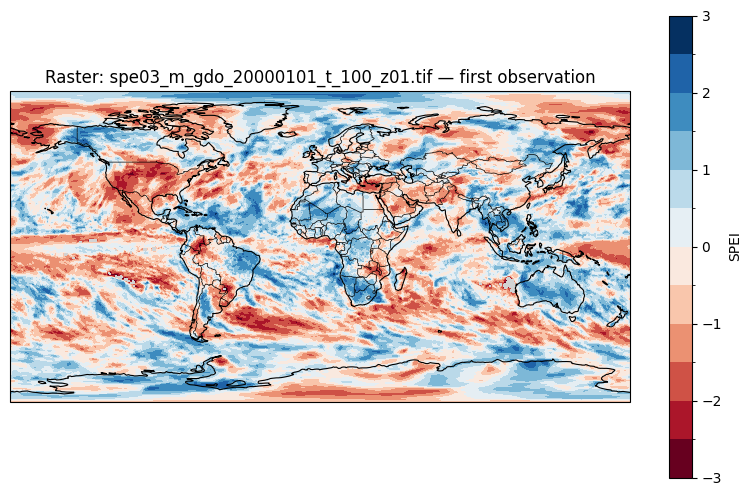

Raster geographic bounds (minx, maxx, miny, maxy): [-180.0, 180.0, -90.0, 90.0]


In [3]:
#Pick the first raster observation 01.01.2000 to demonstrate
first_row = df_tiffs.iloc[0]
img = first_row['data']
folder = first_row['folder']
file = first_row['file']
file_path = os.path.join(data_dir, folder, file)


# --- Reopen raster to get transform and CRS ---
with rasterio.open(file_path) as src:
    transform = src.transform
    crs = src.crs
    # Compute geographic bounds
    h, w = src.height, src.width
    minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform)
    extent = [minx, maxx, miny, maxy] # this is essentially: (min_lon, max_lon, min_lat, max_lat)

# --- Mask invalid values ---
masked = np.ma.masked_invalid(img)

cmap_name = 'RdBu_r'
cmap = colormaps[cmap_name].copy().reversed()
cmap.set_bad(color='lightgray')

bounds = np.linspace(-3, 3, 13) # bounds the colors for the map an center at 0 for consistency / interpretability
norm = BoundaryNorm(bounds, ncolors=cmap.N)

# Plot raster with world map
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())


# Plot raster
ax.imshow(
    masked,
    origin='upper',
    extent=extent,        
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree()
)

# Add map features with (Borders and ocean / land)
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5) # bigger for interpretability
ax.add_feature(cfeature.LAND, facecolor='none', edgecolor='black', linewidth=0.3)

# Labels and title
plt.colorbar(ax.images[0], ax=ax, label="SPEI")
plt.title(f"Raster: {file} — first observation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()

# Print raster extent info just as check
print("Raster geographic bounds (minx, maxx, miny, maxy):", extent) #just to  if lat and long


### Plot over Europe
This is just as show and comparison to Armenia

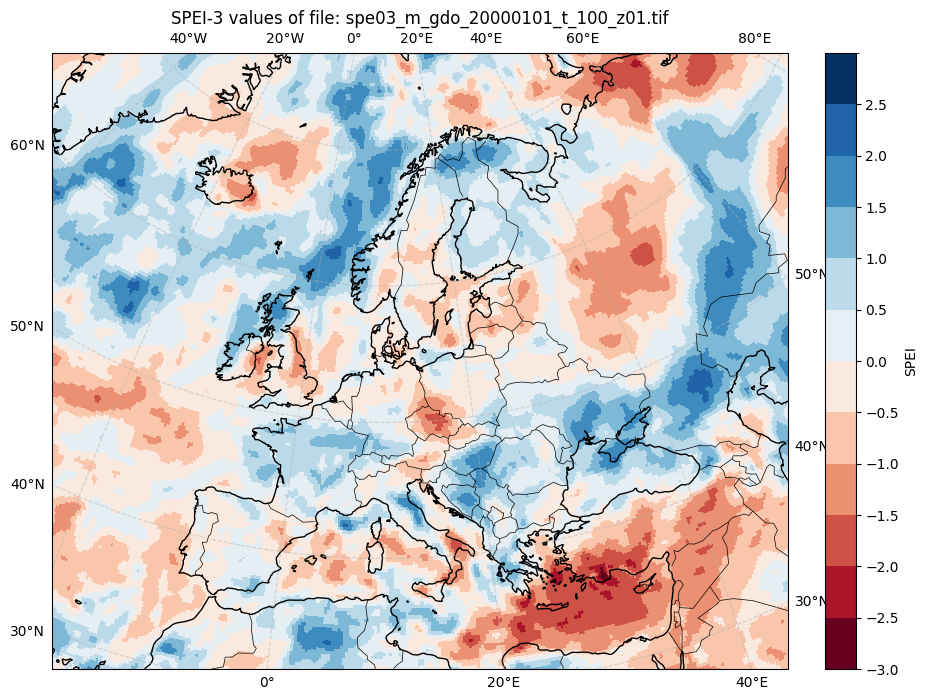

In [4]:

# Colormap and normalized at 0
cmap_name = 'RdBu_r'
cmap = colormaps[cmap_name].copy().reversed()
cmap.set_bad(color='lightgray')

bounds = np.linspace(-3, 3, 13)
norm = BoundaryNorm(bounds, ncolors=cmap.N)

# Pick first file again
row = df_tiffs.iloc[0]
file_path = os.path.join(data_dir, row['folder'], row['file'])

# Reopen the tif to get affine transform/crs -> need to transfor later
with rasterio.open(file_path) as src:
    img = src.read(1)
    transform = src.transform
    crs = src.crs

# Mask invalid values (NaNs)
masked = np.ma.masked_invalid(img)

# Compute raster extent -> same as before
h, w = img.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform)
extent = [minx, maxx, miny, maxy]

# Use EPSG:3035 projection for the map
map_crs = ccrs.epsg(3035) #europe is in epsg:3035 this is a specific european projection type

# Plot in EPSG:3035 but raster transform is PlateCarree (EPSG:4326)
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'projection': map_crs})

im = ax.imshow(masked, origin='upper', extent=extent, transform=ccrs.PlateCarree(), #makes sure to reproject everything correctly
               cmap=cmap, norm=norm)

# Zoom to Europe in EPSG:3035 (meters)
eu_extent_3035 = [1600000, 7600000, 750000, 6000000]  # in meters
ax.set_extent(eu_extent_3035, crs=map_crs) #uses espg:3035 transform above makes sure that the difference in projection is handled

# Add features / borders
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)
ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)

# Colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=bounds[:-1])
cbar.set_label('SPEI')

ax.set_title(f"SPEI-3 values of file: {row['file']}")
plt.show()


# Go to Armenia

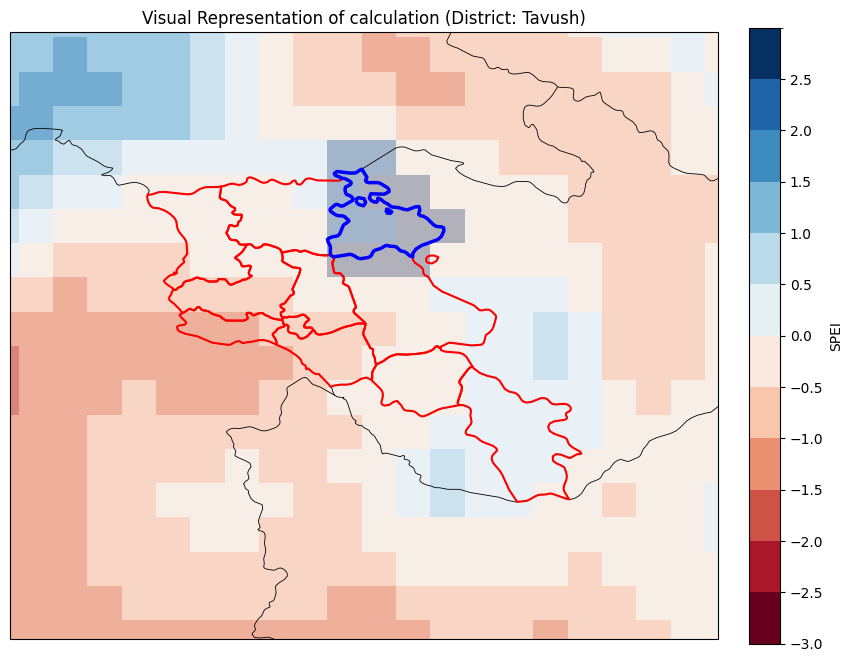

In [5]:
notebook_dir = Path().resolve()
parent_dir = notebook_dir.parent

# Colormap from above

# Pick file (also same as before)
row = df_tiffs.iloc[0]
file_path = os.path.join(data_dir, row["folder"], row["file"])

with rasterio.open(file_path) as src:
    img = src.read(1)
    transform = src.transform
    crs = src.crs

masked = np.ma.masked_invalid(img)
h, w = img.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform)
extent = [minx, maxx, miny, maxy]

# Load Armenia shapefile
districts_fp = parent_dir /"armenia_shapefile/am.json"
districts = gpd.read_file(districts_fp).to_crs(crs)

# Select one district as example (Tavush)
district_name = "Tavush"
district = districts[districts["name"] == district_name].iloc[0]
geom = [district.geometry]

# --- Create mask (True for outside district) ---
mask = geometry_mask(
    geom,
    out_shape=masked.shape,
    transform=transform,
    invert=True, 
    all_touched=True  # Every pixel that touches the polygon of district is included
)

# Visualization of selection process
map_crs = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": map_crs})

# Add features (Borders -> not Districts that is gdp shapefile)
ax.coastlines(resolution="110m", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.add_feature(cfeature.LAND, facecolor="none", edgecolor="black", linewidth=0.3)

# Base SPEI raster
im = ax.imshow(masked, origin="upper", extent=extent, transform=map_crs,
               cmap=cmap, norm=norm)

# Overlay Armenia distric borders
districts.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5, transform=map_crs)

# Overlay mask as transparent blue overlay where district pixels are selected
#essentially masks are a overlay that are true for selected pixels and false for others
masked_overlay = np.zeros_like(masked, dtype=float)
masked_overlay[mask] = 1  # mark selected pixels
ax.imshow(masked_overlay, origin="upper", extent=extent, transform=map_crs,
           cmap="Blues", alpha=0.3)

# Highlight the selected district outline
gpd.GeoSeries([district.geometry]).boundary.plot(ax=ax, edgecolor="blue", linewidth=2.5, transform=map_crs)

# Zoom to Armenia based on shapefile position
minx, miny, maxx, maxy = districts.total_bounds
ax.set_extent([minx - 1, maxx + 1, miny - 1, maxy + 1], crs=map_crs) # add tolerance so map isnt claustrophobic

#Colorbar
cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04, ticks=bounds[:-1])
cbar.set_label("SPEI")

ax.set_title(f"Visual Representation of calculation (District: {district_name})")
plt.show()


# Calculate Distict Averages

In [6]:
# Prepare container for results
results = []

base_dir = data_dir

# Loop for all files again -> then loop over that
all_files = []
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    for file in os.listdir(folder_path):
        if file.endswith(".tif"):
            all_files.append((folder, os.path.join(folder_path, file)))

# Loop over all files with tqdm to see progress bar as it can take a while (me about 3min)
for folder, file_path in tqdm(all_files, desc="Processing raster files"): #loop over each file
    with rasterio.open(file_path) as src:
        img = src.read(1)
        transform = src.transform
        crs = src.crs

        masked = np.ma.masked_invalid(img) #mask invalid values
        districts_proj = districts.to_crs(crs) # get districs

        for idx, dist in districts_proj.iterrows(): # loop over every district
            geom = [dist.geometry] #select distric geometry

            mask = rasterize(
                [(dist.geometry, 1)],
                out_shape=masked.shape,
                transform=transform,
                all_touched=True,  # Every pixel that touches the polygon of district is included
                fill=0,
                dtype=np.uint8
            ).astype(bool)

            values = masked[mask] #select values in distric

            mean_value = np.nan #make nan by default
            if values.size > 0: #overwrite if there are values (elements in array)
                mean_value = values.mean()

            results.append({
                "folder": folder,
                "file": os.path.basename(file_path),
                "district": dist["name"],
                "mean_spei": mean_value
            })

# Convert to DataFrame
df_districts_spei = pd.DataFrame(results)
print(df_districts_spei.head())


Processing raster files: 100%|██████████| 930/930 [03:27<00:00,  4.49it/s]

                            folder                                file  \
0  spe03_m_gdo_20000101_20001221_t  spe03_m_gdo_20000101_t_100_z01.tif   
1  spe03_m_gdo_20000101_20001221_t  spe03_m_gdo_20000101_t_100_z01.tif   
2  spe03_m_gdo_20000101_20001221_t  spe03_m_gdo_20000101_t_100_z01.tif   
3  spe03_m_gdo_20000101_20001221_t  spe03_m_gdo_20000101_t_100_z01.tif   
4  spe03_m_gdo_20000101_20001221_t  spe03_m_gdo_20000101_t_100_z01.tif   

      district  mean_spei  
0       Tavush  -0.074052  
1         Lori  -0.155174  
2       Shirak  -0.408265  
3  Gegharkunik  -0.185340  
4  Vayots Dzor  -0.134853  


In [7]:
df_worker = df_districts_spei.copy()
df_worker['date'] = pd.to_datetime(df_worker['file'].str.extract(r'(\d{8})')[0], format='%Y%m%d')
df_worker.drop(columns=['folder', 'file'], inplace=True)
df_worker.to_csv(parent_dir / 'drought_data_output/spei3_hf_raw.csv', index=False)